In [20]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [21]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

In [22]:
print(train.shape, test.shape, submission.shape)

(472972, 3) (1418916, 2) (1418916, 2)


In [23]:
train.head()

,id,level,full_log
0,0,0,"Sep 24 10:02:22 localhost kibana: {""type"":""err..."
1,1,0,Feb 8 16:21:00 localhost logstash: [2021-02-0...
2,2,0,"Jan 13 01:50:40 localhost kibana: {""type"":""err..."
3,3,0,"Jan 4 10:18:31 localhost kibana: {""type"":""err..."
4,4,1,type=SYSCALL msg=audit(1603094402.016:52981): ...


In [24]:
test.head()

,id,full_log
0,1000000,"Feb 8 15:47:26 localhost kibana: {""type"":""err..."
1,1000001,"Sep 24 03:46:39 localhost kibana: {""type"":""err..."
2,1000002,type=SYSCALL msg=audit(1611888200.428:210563):...
3,1000003,"Jan 18 11:24:06 localhost kibana: {""type"":""err..."
4,1000004,type=SYSCALL msg=audit(1603081202.050:46851): ...


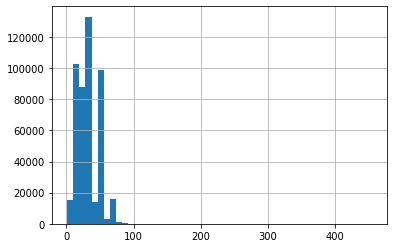

In [25]:
train['full_log'].str.split(' ').str.len().hist(bins=50)

In [26]:
train['level'].value_counts()

0    334065
1    132517
3      4141
5      2219
2        12
4        10
6         8
Name: level, dtype: int64

In [27]:
train['full_log']=train['full_log'].str.replace(r'[0-9]', '<num>')
test['full_log']=test['full_log'].str.replace(r'[0-9]', '<num>')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [28]:
train_text=list(train['full_log'])
train_level=np.array(train['level'])

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(analyzer="word", max_features=10000)

train_features=vectorizer.fit_transform(train_text)

In [30]:
train_features

<472972x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 16452589 stored elements in Compressed Sparse Row format>

In [31]:
TEST_SIZE=0.2
RANDOM_SEED=42

train_x, eval_x, train_y, eval_y=train_test_split(train_features, train_level, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest=RandomForestClassifier(n_estimators=100)

forest.fit(train_x, train_y)

RandomForestClassifier()

In [33]:
forest.score(eval_x, eval_y)

0.9978434378138379

In [34]:
pred=forest.predict(eval_x)
crosstab = pd.crosstab(eval_y, pred, rownames=['real'], colnames=['pred'])
crosstab

pred,0,1,2,3,4,5
real,,,,,,
0,66724,59,0,0,0,3
1,121,26425,0,0,0,1
2,0,0,2,0,0,0
3,1,1,0,799,0,0
4,0,0,0,0,3,0
5,12,3,0,0,0,438
6,1,0,0,2,0,0


In [35]:
preds=forest.predict(eval_x)
probas=forest.predict_proba(eval_x)
print(preds.shape)
print(probas.shape)

(94595,)
(94595, 7)


In [36]:
preds[np.where(np.max(probas, axis=1)<0.90)]=7
new_crosstab = pd.crosstab(eval_y, preds, rownames=['real'], colnames=['pred'])
new_crosstab

pred,0,1,2,3,4,5,7
real,,,,,,,
0,66507,1,0,0,0,0,278
1,19,26407,0,0,0,0,121
2,0,0,2,0,0,0,0
3,0,0,0,790,0,0,11
4,0,0,0,0,3,0,0
5,3,0,0,0,0,433,17
6,0,0,0,0,0,0,3


In [37]:
test_text=list(test['full_log'])
ids=list(test['id'])

In [38]:
test_features=vectorizer.transform(test_text)

In [39]:
results=forest.predict(test_features)
results_proba=forest.predict_proba(test_features)
results[np.where(np.max(results_proba, axis=1) < 0.9)] = 7

In [40]:
submission['level']=results

In [41]:
submission

,id,level
0,1000000,0
1,1000001,0
2,1000002,1
3,1000003,0
4,1000004,1
...,...,...
1418911,2418911,0
1418912,2418912,0
1418913,2418913,1
1418914,2418914,0


In [42]:
submission.to_csv('baseline_submission.csv', index=False)